### Считывание кластеризованных данных

In [1]:
import os
import pandas as pd

os.chdir('../../../')

In [14]:
df = pd.read_csv('data/lmsys-chat-1m/processed/kmeans_clusters.csv')
df.head()

,user_id,neutral_count,positive_count,negative_count,total_reformulations,total_words,total_spelling_errors,total_questions,cluster
0,0,0.000000,1.0,0.000000,0.0,11.0,0.0,0.000000,1
1,1,0.333333,0.5,0.166667,0.5,25.0,0.5,0.666667,1
2,2,0.000000,1.0,0.000000,0.0,66.0,0.0,0.000000,1
3,3,0.500000,0.5,0.000000,0.0,14.5,0.0,0.000000,0
4,4,1.000000,0.0,0.000000,0.0,18.0,3.0,0.000000,0


### Обучение классификатора


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from scipy.stats import randint
import time

X = df.drop(['user_id', 'cluster'], axis=1)
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [None] + list(range(5, 30, 5)),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2', None]
}

model = RandomForestClassifier(random_state=42, n_jobs=-1)
search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=1,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

start = time.time()
search.fit(X_train, y_train)
end = time.time()

print(f"Лучшая модель: {search.best_params_}")
print(f"Время подбора: {round(end - start, 2)} секунд")

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("Результаты на тесте:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшая модель: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 121}
Время подбора: 106.58 секунд
Результаты на тесте:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11437
           1       1.00      1.00      1.00      8523
           2       1.00      0.99      1.00       324
           3       0.99      0.99      0.99      2065
           4       1.00      1.00      1.00      3351
           5       1.00      0.99      0.99       233

    accuracy                           1.00     25933
   macro avg       1.00      0.99      1.00     25933
weighted avg       1.00      1.00      1.00     25933



### Почему такие хорошие параметры

Скорее всего, random forest очень хорошо справился из-за дублей. Однако:

- Мы работаем с нормализованными поведенческими признаками;
- Важна типология пользователей — а она по определению может повторяться;
- Большинство пользователей короткие (мало слов) — значит, дубли - неотъемлемая часть типового кластера.

Таким образом - дублирование является следствием реального распределения поведения пользователей, где однотипные паттерны повторяются.


### Проверка на переобучение

In [16]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 0.9998
Test accuracy:  0.9981


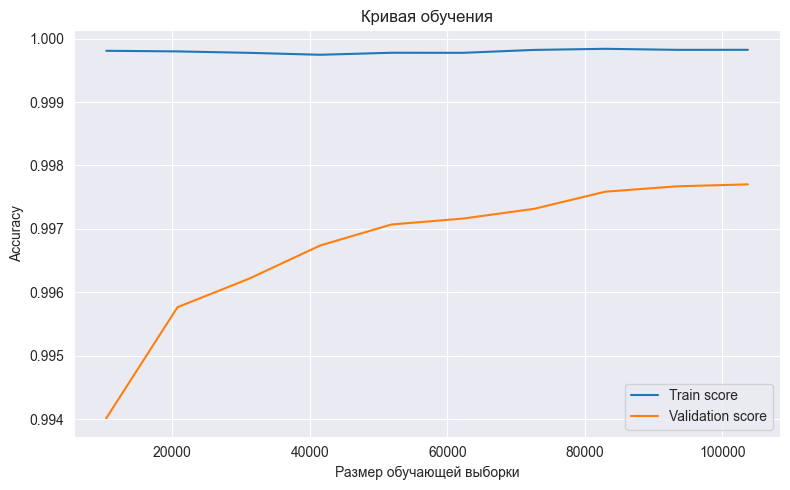

In [17]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Сохраняем модель

In [18]:
import joblib

joblib.dump(best_model, 'models/random_forest/model.pkl')

['models/random_forest/model.pkl']

### Проверка без дубликатов

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from scipy.stats import randint
import time

X = df.drop(['user_id', 'cluster'], axis=1)
y = df['cluster']
X = X.drop_duplicates()
y = y.loc[X.index]  # пересинхронизация y

print(f"Размер X после drop_duplicates(): {X.shape[0]}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [None] + list(range(5, 30, 5)),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2', None]
}

model = RandomForestClassifier(random_state=42, n_jobs=-1)
search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,  # можно увеличить
    cv=5,
    verbose=1,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

start = time.time()
search.fit(X_train, y_train)
end = time.time()

print(f"Лучшая модель: {search.best_params_}")
print(f"Время подбора: {round(end - start, 2)} секунд")

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("Результаты на тесте:")
print(classification_report(y_test, y_pred))


Размер X после drop_duplicates(): 39489
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшая модель: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 121}
Время подбора: 40.73 секунд
Результаты на тесте:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3096
           1       0.99      0.99      0.99      1936
           2       0.99      0.99      0.99       252
           3       0.99      0.98      0.99      1211
           4       0.99      0.99      0.99      1195
           5       0.98      0.99      0.98       208

    accuracy                           0.99      7898
   macro avg       0.99      0.99      0.99      7898
weighted avg       0.99      0.99      0.99      7898



### Проверка на переобучение

In [20]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")


Train accuracy: 0.9995
Test accuracy:  0.9918


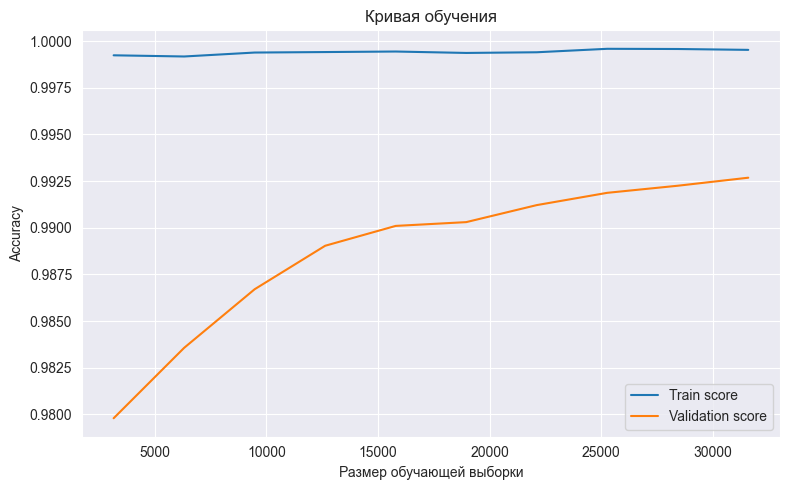

In [21]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Сохраняем модель

In [22]:
import joblib

joblib.dump(best_model, 'models/random_forest/model_wo_duplicates.pkl')

['models/random_forest/model_wo_duplicates.pkl']